In [1]:
import os
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
from sklearn.utils import shuffle
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import cv2
import numpy as np
from skimage.transform import resize
from skimage.filters import threshold_otsu, gaussian
import cv2

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
test_targets = np.load('test_targets2.npy')
y_test = np.load('y_test_targets2.npy')  

In [3]:
test_targets = test_targets.squeeze()

# Centreren 

In [4]:
# --- Functies ---
def resize_with_padding(img, target_size=64, inner_size=60):
    h, w = img.shape
    scale = min(inner_size / h, inner_size / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = resize(img, (new_h, new_w), mode='constant', anti_aliasing=True)
    pad_h, pad_w = target_size - new_h, target_size - new_w
    top, bottom = pad_h // 2, pad_h - pad_h // 2
    left, right = pad_w // 2, pad_w - pad_w // 2
    return np.pad(resized, ((top, bottom), (left, right)), mode='constant', constant_values=0)

def crop_and_pad(img):
    img = img / 255.0 if img.max() > 1 else img
    threshold = threshold_otsu(img)
    binary = img > threshold
    if not np.any(binary):
        return np.zeros((64, 64))
    rows, cols = np.any(binary, axis=1), np.any(binary, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    margin = 1
    rmin, rmax = max(rmin - margin, 0), min(rmax + margin, img.shape[0] - 1)
    cmin, cmax = max(cmin - margin, 0), min(cmax + margin, img.shape[1] - 1)
    cropped = img[rmin:rmax+1, cmin:cmax+1]
    padded = resize_with_padding(cropped)
    return padded

# Witte vlekken

In [5]:
def add_freely_growing_connected_blobs(images, num_blobs_range=(1, 3), blob_size_range=(8, 15), growth_steps=3, step_size_range=(5, 8)):
    augmented_images = []
    
    for img in images:
        img = img.copy()

        if img.ndim == 3:
            img = img[..., 0]

        _, binary = cv2.threshold((img * 255).astype(np.uint8), 30, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            augmented_images.append(img)
            continue
        
        cnt = max(contours, key=cv2.contourArea)
        h, w = img.shape
        num_blobs = np.random.randint(num_blobs_range[0], num_blobs_range[1] + 1)

        for _ in range(num_blobs):
            point_idx = np.random.randint(0, len(cnt))
            point = cnt[point_idx][0]

            blob_width = np.random.randint(blob_size_range[0], blob_size_range[1])
            blob_height = np.random.randint(blob_size_range[0] // 2, blob_size_range[1] // 2)

            center = (point[0], point[1])

            for step in range(growth_steps):
                axes = (blob_width // 2, blob_height // 2)
                angle = np.random.randint(0, 360)
                cv2.ellipse(img, center, axes, angle, 0, 360, (1.0,), thickness=-1)

                # Kies nieuwe random richting
                grow_direction = np.random.uniform(-np.pi, np.pi)
                step_size = np.random.randint(step_size_range[0], step_size_range[1])

                dx = int(step_size * np.cos(grow_direction))
                dy = int(step_size * np.sin(grow_direction))

                new_center = (np.clip(center[0] + dx, 0, w - 1), np.clip(center[1] + dy, 0, h - 1))

                # Vul de ruimte tussen oude center en nieuwe center
                num_interp = int(np.hypot(new_center[0] - center[0], new_center[1] - center[1])) // 2
                for t in np.linspace(0, 1, num_interp):
                    interp_x = int((1 - t) * center[0] + t * new_center[0])
                    interp_y = int((1 - t) * center[1] + t * new_center[1])
                    cv2.circle(img, (interp_x, interp_y), radius=blob_width//4, color=(1.0,), thickness=-1)

                center = new_center

        augmented_images.append(img)

    return np.array(augmented_images)


In [6]:
test_targets_processed = np.array([crop_and_pad(img) for img in test_targets], dtype=np.float32)

corrupted_test_inputs_wit = add_freely_growing_connected_blobs(test_targets_processed)

corrupted_test_inputs_wit = np.expand_dims(corrupted_test_inputs_wit, axis=-1).astype(np.float32)
np.save("test_inputs_wit.npy", corrupted_test_inputs_wit)

print("Bestand test_inputs_with_blobs.npy is opgeslagen.")


Bestand test_inputs_with_blobs.npy is opgeslagen.


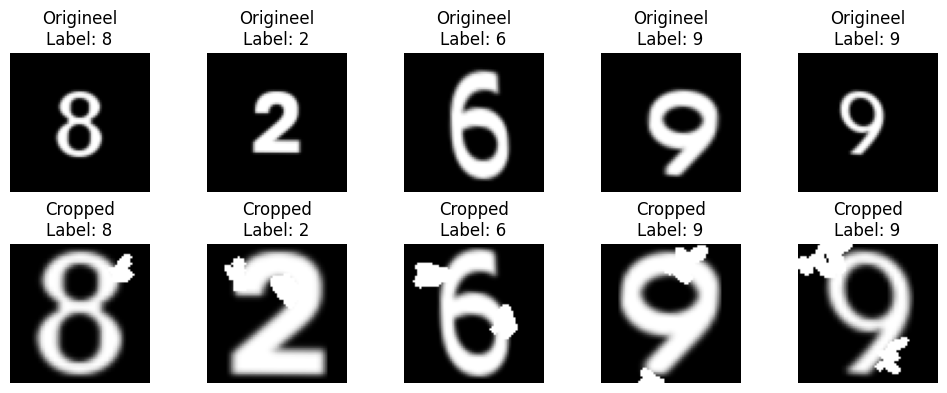

In [7]:
import matplotlib.pyplot as plt

# Aantal voorbeelden om te tonen
n = 5

plt.figure(figsize=(10, 4))
for i in range(n):
    # Originele afbeelding met label
    plt.subplot(2, n, i + 1)
    img = test_targets[i]
    if img.ndim == 3:
        img = img.squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f'Origineel\nLabel: {y_test[i]}')
    plt.axis('off')

    # Bewerkte afbeelding met label
    plt.subplot(2, n, i + 1 + n)
    processed = corrupted_test_inputs_wit[i]
    plt.imshow(processed, cmap='gray')
    plt.title(f'Cropped\nLabel: {y_test[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Zwarte vlekken

In [8]:
import numpy as np
import cv2

def add_smart_black_damage(images):
    """
    Brengt zwarte vlekken aan rond contouren van cijfers om skeleton-connectiviteit te verstoren.
    """
    augmented_images = []

    for img in images:
        img = img.copy()

        if img.ndim == 3:
            img = img[..., 0]

        h, w = img.shape
        binary = (img * 255).astype(np.uint8)
        _, binary_thresh = cv2.threshold(binary, 30, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            augmented_images.append(img)
            continue

        cnt = max(contours, key=cv2.contourArea)

        # Bepaal verstoringsniveau (medium / high)
        damage_level = np.random.choice(['medium', 'high'], p=[0.7, 0.3])

        if damage_level == 'medium':
            num_blobs_range = (2, 4)
            blob_size_range = (10, 14)
            growth_steps = 4
            step_size_range = (3, 6)
        else:
            num_blobs_range = (1, 2)
            blob_size_range = (18, 22)
            growth_steps = 6
            step_size_range = (5, 8)

        num_blobs = np.random.randint(*num_blobs_range)

        for _ in range(num_blobs):
            # Kies punt op de contour als start
            point_idx = np.random.randint(0, len(cnt))
            point = cnt[point_idx][0]
            center = (point[0], point[1])

            blob_width = np.random.randint(*blob_size_range)
            blob_height = np.random.randint(blob_size_range[0] // 2, blob_size_range[1] // 2)

            for _ in range(growth_steps):
                axes = (blob_width // 2, blob_height // 2)
                angle = np.random.randint(0, 360)

                # Teken zwarte ellips
                cv2.ellipse(img, center, axes, angle, 0, 360, (0,), thickness=-1)

                # Bepaal groeirichting
                grow_angle = np.random.uniform(-np.pi, np.pi)
                step_size = np.random.randint(*step_size_range)
                dx = int(step_size * np.cos(grow_angle))
                dy = int(step_size * np.sin(grow_angle))

                new_center = (
                    np.clip(center[0] + dx, 0, w - 1),
                    np.clip(center[1] + dy, 0, h - 1)
                )

                # Interpoleer tussen oud en nieuw centrum
                dist = np.hypot(new_center[0] - center[0], new_center[1] - center[1])
                num_interp = max(1, int(dist) // 2)
                for t in np.linspace(0, 1, num_interp):
                    interp_x = int((1 - t) * center[0] + t * new_center[0])
                    interp_y = int((1 - t) * center[1] + t * new_center[1])
                    cv2.circle(img, (interp_x, interp_y), radius=blob_width // 4, color=(0,), thickness=-1)

                center = new_center

        augmented_images.append(img)

    return np.array(augmented_images)


In [ ]:
test_targets_processed = np.array([crop_and_pad(img) for img in test_targets], dtype=np.float32)
corrupted_test_inputs_zwart = add_smart_black_damage(test_targets_processed)
corrupted_test_inputs_zwart = np.expand_dims(corrupted_test_inputs_zwart, axis=-1).astype(np.float32)
np.save("test_inputs_zwart.npy", corrupted_test_inputs_zwart)


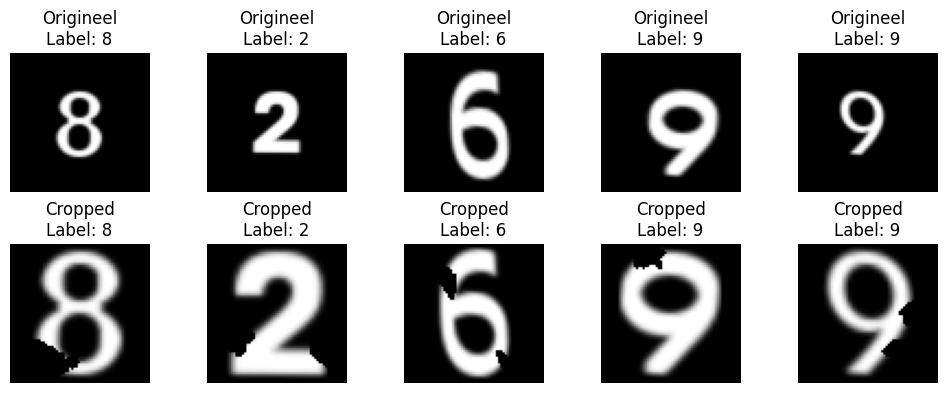

In [10]:
import matplotlib.pyplot as plt

# Aantal voorbeelden om te tonen
n = 5

plt.figure(figsize=(10, 4))
for i in range(n):
    # Originele afbeelding met label
    plt.subplot(2, n, i + 1)
    img = test_targets[i]
    if img.ndim == 3:
        img = img.squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f'Origineel\nLabel: {y_test[i]}')
    plt.axis('off')

    # Bewerkte afbeelding met label
    plt.subplot(2, n, i + 1 + n)
    processed = corrupted_test_inputs_zwart[i]
    plt.imshow(processed, cmap='gray')
    plt.title(f'Cropped\nLabel: {y_test[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Volledig corrupt

In [13]:
def augment_image(img):
    choice = np.random.choice(['white', 'black', 'both'])

    if choice == 'white':
        img_aug = add_freely_growing_connected_blobs([img])[0]
    elif choice == 'black':
        img_aug = add_smart_black_damage([img])[0]
    else:  # both
        img_white = add_freely_growing_connected_blobs([img])[0]
        img_aug = add_smart_black_damage([img_white])[0]
    
    return img_aug


In [14]:
# Stap 1: Preprocess de originele beelden
test_targets_processed = np.array([crop_and_pad(img) for img in test_targets], dtype=np.float32)

# Stap 2: Combineer augmentaties (wit/zwart/both)
corrupted_test_inputs_aug = np.array([augment_image(img) for img in test_targets_processed], dtype=np.float32)

# Stap 3: Zorg voor juiste CNN-invoerformaat
corrupted_test_inputs_aug = np.expand_dims(corrupted_test_inputs_aug, axis=-1)

# Stap 4: Opslaan
np.save("test_inputs_aug.npy", corrupted_test_inputs_aug)


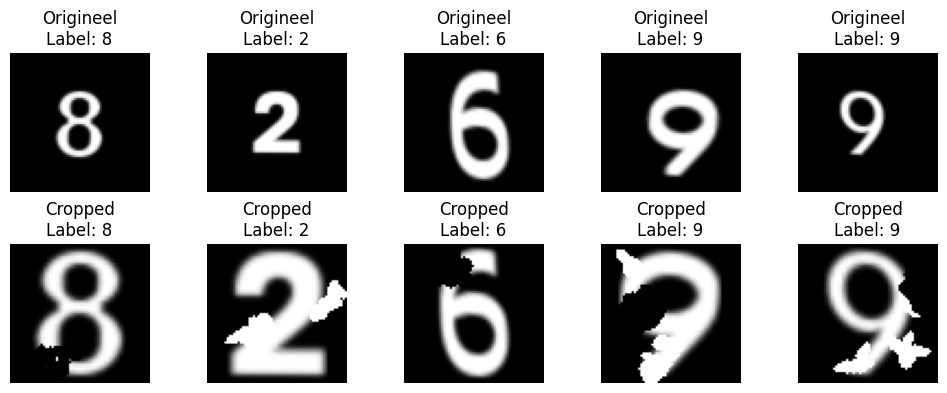

In [15]:
import matplotlib.pyplot as plt

# Aantal voorbeelden om te tonen
n = 5

plt.figure(figsize=(10, 4))
for i in range(n):
    # Originele afbeelding met label
    plt.subplot(2, n, i + 1)
    img = test_targets[i]
    if img.ndim == 3:
        img = img.squeeze()
    plt.imshow(img, cmap='gray')
    plt.title(f'Origineel\nLabel: {y_test[i]}')
    plt.axis('off')

    # Bewerkte afbeelding met label
    plt.subplot(2, n, i + 1 + n)
    processed = corrupted_test_inputs_aug[i]
    plt.imshow(processed, cmap='gray')
    plt.title(f'Cropped\nLabel: {y_test[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()
